In [3]:
import time
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import mean_absolute_error
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA

import seaborn as sns
import dataframe_image as dfi



In [2]:
!pip install dataframe_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.8 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 63.1 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def open_dataframe(in_file="/content/drive/MyDrive/Colab Notebooks/traditional_methods/data/crocus.csv"):
  # Load df from file
  in_file = os.path.join(in_file)
  df = pd.read_csv(in_file, header=0, index_col='crocus_id', parse_dates=["datetime"])
  if any(df.loc['Crocus-024']):
    df.drop('Crocus-024', inplace=True)
  return df

In [ ]:
def cross_validation(model_func, features, feature_folder, model_folder, yeo_johnson=False, pca=False, scale=True):
  """This function takes a model and a list of features and will perform cross validation for that model and feature set"""
  file_check = "/content/drive/MyDrive/Colab Notebooks/traditional_methods/results/"+ feature_folder + model_folder +".csv"
  if os.path.exists(file_check):
    print("done", file_check)
    return 
  print("not done", file_check)

  df = open_dataframe()
  run_list = sorted(list(set(df.index)))
  run_list_iter = run_list
  results_ls = []
  # iterate through runs
  for run in run_list_iter:
    # split into test and training runs
    test_run = run
    training_runs = [x for x in run_list if x != run]
    # split data into test and train data
    train_df = df.loc[training_runs]
    test_df = df.loc[run]
    # split data into x and y for test and training
    x_train = train_df[features]
    y_train = train_df['Product']
    x_test = test_df[features]
    y_test = test_df['Product']
    # # Scale and then power transform data
    if scale is True:
      ss = StandardScaler()
      x_train = ss.fit_transform(x_train)
      x_test = ss.transform(x_test)
    if pca is True:
        for i in range(1, len(features)):
          print(i)
          pca = PCA(n_components=i)
          principalComponents = pca.fit_transform(x_train)
          print(f'with {i} principal components explained variance is:', pca.explained_variance_ratio_,
                "and the total is:", sum(pca.explained_variance_ratio_))
          if sum(pca.explained_variance_ratio_) > 0.95:
              break
        x_train = pca.fit_transform(x_train)
        x_test = pca.transform(x_test)
    # if yeo-johnson is true then power transform the data
    if yeo_johnson is True:
      pt = PowerTransformer(method='yeo-johnson')
      x_train = pt.fit_transform(x_train)
      x_test = pt.transform(x_test)
    # train model
    trained_model = model_func(x_train, y_train)
    # test model
    y_pred = trained_model.predict(x_test)
    # evaluate predictions
    mae = mean_absolute_error(y_test, y_pred)
    # plots

      # plt.text(1, 25, mae)
      # plt.xlim(0, 40)
      # plt.ylim(0, 40)
      # plt.plot(y_pred, y_test, linewidth=2, label=test_run, c='black')
      # plt.ylabel('Actual')
      # plt.xlabel('Predictions')
      # plt.show()

    # per file, only 1 model, 1 feature set but each cross validation (10 runs)
    results_df = pd.DataFrame({'test_run': [test_run], 'training_runs': [training_runs], 'features': [features], 'model': [model_folder], 'mae': [mae]})
    results_ls.append(results_df)
  cv_results_df = pd.concat(results_ls)
  average_mae = np.mean(cv_results_df['mae'])
  average_row = pd.DataFrame({'test_run': 'average', 'training_runs': 'average', 'features': [features], 'model': [model_folder], 'mae': average_mae})
  cv_results_df_save = pd.concat([cv_results_df, average_row])
  # if no folder, make a new one
  directory_check = "/content/drive/MyDrive/Colab Notebooks/traditional_methods/results/"+ feature_folder
  if not os.path.exists(directory_check):
    os.makedirs(directory_check)
  cv_results_df_save.to_csv("/content/drive/MyDrive/Colab Notebooks/traditional_methods/results/"+ feature_folder + model_folder +".csv")


In [ ]:
from pickle import TRUE
feature_ls1 = ['green_cumulative']
feature_ls2 = ['green', 'red', 'blue', 'uvaI', 'uvaE', 'uvbE', 'uvbI', 'stirRate', 
               'pressureE', 'humidity', 'temperature', 'best_temperature', 'hydrazine_batches', 
               'luminance_percent', 'saturation', 'hue', 'red_cumulative', 'blue_cumulative', 
               'green_cumulative', 'pressureE_cumulative', 'best_temperature_cumulative', 
               'hue_cumulative', 'saturation_cumulative', 'luminance_percent_cumulative', 
               'humidity_cumulative', 'best_temperature_std_dev', 'best_temperature_std_dev_cumulative', 
               'std_dev_over_cum_temp', 'std_dev_cumulative_over_cumulative_temp']
feature_ls3 = ['uvaI', 'uvaE', 'uvbE', 'uvbI', 'stirRate', 
               'pressureE', 'humidity', 'temperature', 'best_temperature', 'hydrazine_batches', 
               'pressureE_cumulative', 'best_temperature_cumulative', 
               'humidity_cumulative', 'best_temperature_std_dev', 'best_temperature_std_dev_cumulative', 
               'std_dev_over_cum_temp', 'std_dev_cumulative_over_cumulative_temp']
feature_ls_ls = [feature_ls2]
model_ls = [linear_regression, polynomial_regression, gradient_boosting_regressor, random_forest]
feature_ls_folder_name_dic = {''.join(feature_ls1): 'Green cumulative/', ''.join(feature_ls2): 'All features/', ''.join(feature_ls3): 'No colour features/'}
for feature_ls in feature_ls_ls:

  for model in model_ls:
    print(feature_ls, model)
    # if polynomial only do green cumulative feature and don't scale
    if model == polynomial_regression:
      if len(feature_ls) > 1:
        continue
      cross_validation(model, feature_ls, feature_ls_folder_name_dic[''.join(feature_ls)], model.__name__, scale=False)
      cross_validation(model, feature_ls, "Yeo-Johnson " + feature_ls_folder_name_dic[''.join(feature_ls)], model.__name__, scale=False, yeo_johnson=True)
    # if not polynomial, 
    else:
      cross_validation(model, feature_ls, feature_ls_folder_name_dic[''.join(feature_ls)], model.__name__)
      if feature_ls == feature_ls1:
        print("yj")
        # if green cumulative repeat with YJ transform
        cross_validation(model, feature_ls, "Yeo-Johnson " + feature_ls_folder_name_dic[''.join(feature_ls)], model.__name__, yeo_johnson=True)
      elif feature_ls == feature_ls2:
        # if all features repeat with pca
        cross_validation(model, feature_ls, "PCA/", model.__name__, pca=True)

In [ ]:
"""Models"""
def linear_regression(x_train, y_train):
    """Runs a linear regressor and sends the object back for evaluation"""
    regressor = LinearRegression(fit_intercept=True)
    regressor.fit(x_train, y_train)
    return regressor

def gradient_boosting_regressor(x_train, y_train):
    """Runs a gradient boosting regressor and sends the object back for evaluation"""
    regressor = GradientBoostingRegressor(n_estimators=1000, random_state=0)
    regressor.fit(x_train, y_train)
    return regressor
  
def random_forest(x_train, y_train):
    """Runs a random forest regressor and sends the object back for evaluation"""
    regressor = RandomForestRegressor(n_estimators=1000, random_state=0)
    regressor.fit(x_train, y_train)
    return regressor

def polynomial_regression(x_train, y_train):
  """Runs a polynomial regressor and sends the object back for evaluation"""
  regressor = PolynomialRegressor()
  regressor.fit(x_train, y_train)
  return regressor

In [ ]:
class PolynomialRegressor:
  """For polynomial regressor model"""
  def __init__(self):
    pass

  def cubic_polynomial(self, x, a, b, c, d=0):
    z = a * x + b * x ** 2 + c * x ** 3 + d
    return z

  def fit_transform(self, x, y):
    # need to reshape arrrays
    n = len(x)
    assert n == len(y), "x and y must have same length"
    x, y = x.values.reshape(n,), y.values.reshape(n, )
    self.coeffs, cov = curve_fit(f=self.cubic_polynomial, xdata=x, ydata=y, p0=[0, 0, 0], bounds=(-np.inf, np.inf))
    y_train_pred = self.cubic_polynomial(x_train, *self.coeffs)
    return y_train_pred

  def fit(self, x, y):
    n = len(x)
    assert n == len(y), "x and y must have same length"
    if isinstance(x, np.ndarray):
      x, y = x.reshape(n,), y.values.reshape(n, )
    elif isinstance(x, pd.Series):
      x, y = x.values.reshape(n,), y.values.reshape(n, )
    self.coeffs, cov = curve_fit(f=self.cubic_polynomial, xdata=x, ydata=y, p0=[0, 0, 0], bounds=(-np.inf, np.inf))

  def predict(self, x):
    n = len(x)
    if isinstance(x, np.ndarray):
      x = x.reshape(n, )
    elif isinstance(x, pd.Series):
      x = x.values.reshape(n,)
    y_pred = self.cubic_polynomial(x, *self.coeffs)
    return y_pred


                        Features                        Model       MAE
0               Green cumulative        polynomial_regression  3.622193
1               Green cumulative                random_forest  4.401938
2               Green cumulative  gradient_boosting_regressor  4.102956
3               Green cumulative            linear_regression  4.202892
4                   All features            linear_regression  5.822582
5                   All features                random_forest  5.689105
6                   All features  gradient_boosting_regressor  3.908309
7             No colour features            linear_regression  8.463917
8             No colour features                random_forest  8.245921
9             No colour features  gradient_boosting_regressor  7.097575
10  Yeo-Johnson Green cumulative            linear_regression  3.756865
11  Yeo-Johnson Green cumulative  gradient_boosting_regressor  4.101797
12  Yeo-Johnson Green cumulative                random_forest  4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


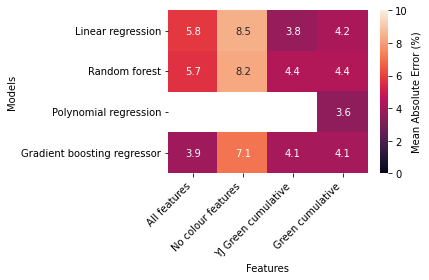

In [5]:
def make_results_matrix():
  # make list of directories
  dir_ls = os.listdir("/content/drive/MyDrive/Colab Notebooks/traditional_methods/results")
  results_ls = []
  for dir in dir_ls:
    # file list
    file_ls = os.listdir("/content/drive/MyDrive/Colab Notebooks/traditional_methods/results/"+dir)
    for file in file_ls:
      # for each file go and get the average and save as a dic
      in_file = "/content/drive/MyDrive/Colab Notebooks/traditional_methods/results/"+dir+"/"+file
      df = pd.read_csv(in_file, header=0, index_col='test_run')
      average_row = df.loc['average']
      features, model, mae = dir, average_row['model'], average_row['mae']
      results_dic = {'Features': features, 'Model': model, 'MAE': mae}
      results_ls.append(results_dic)
  results_df = pd.DataFrame(results_ls)
  print(results_df)
  # need to make index models
  df_index = list(set(results_df['Model']))
  print(df_index)
  # need to make columns features
  features = list(set(results_df['Features']))
  print(features)
  new_df = pd.DataFrame(columns=features, index=df_index)
  print(new_df)
  # need to fill dataframe
  row_ls = []
  for model in df_index:
    new_row = {}
    for feature in features:
      # df = results_df[results_df['Model used'] == model]
      # df[(df[Gender]=='Male') & (df[Year]==2014)]
      mae = results_df[(results_df['Features']==feature) & (results_df['Model']==model)]['MAE'].values
      if mae:
        mae = mae[0]
      else:
        mae = np.NaN

      # new_df.loc[model][feature] = results_df['MAE']
      if 'Yeo-Johnson' in feature:
        feature = feature.replace('Yeo-Johnson', 'YJ')
      new_row.update({feature: mae})
    row_ls.append(new_row)
  df_index = [x.capitalize().replace('_', ' ') for x in df_index]
  new_df = pd.DataFrame(row_ls, index=df_index)
  # print(new_df.loc['linear_regression']['Green cumulative'])
  sns.heatmap(new_df, vmin=0, vmax=10, annot=True, cbar_kws={'label': 'Mean Absolute Error (%)'})
  # plt.title("Summary for whole reaction", y=1.05, x=0.4)
  plt.ylabel("Models")
  plt.xlabel("Features")
  # plt.tick_params(axis='x', rotation=45)

  # xticks_pos = [0.65 * patch.get_width() + patch.get_xy()[0] for patch in h]
  plt.xticks(ha='right', rotation=45)
  plt.tight_layout()
  outfile = "/content/drive/MyDrive/Colab Notebooks/traditional_methods/" + 'results_heatmap.png'
  plt.savefig(outfile, dpi=600, bbox_inches='tight')
  plt.show()

make_results_matrix()

Crocus-014 

/n/n


<Figure size 576x576 with 0 Axes>

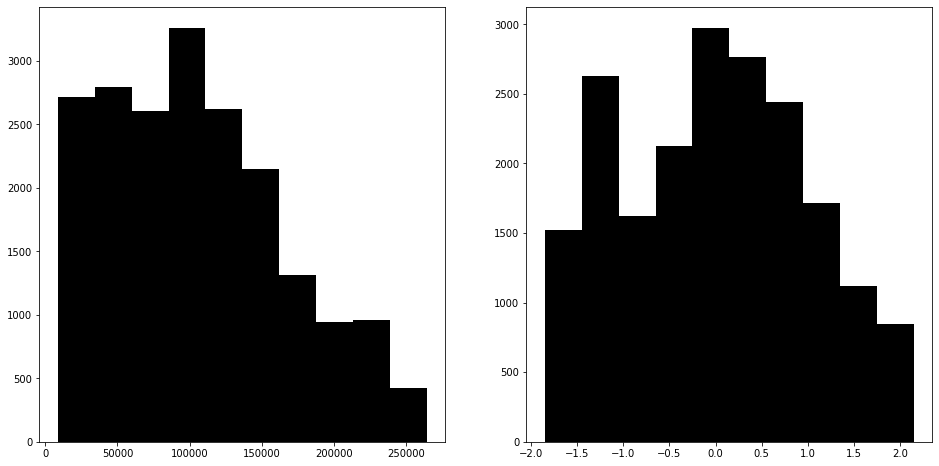

Crocus-015 

/n/n


<Figure size 576x576 with 0 Axes>

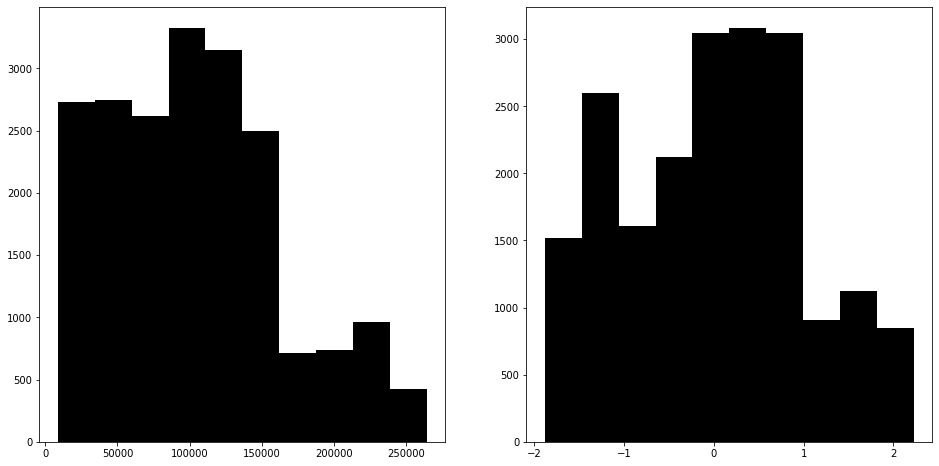

Crocus-016 

/n/n


<Figure size 576x576 with 0 Axes>

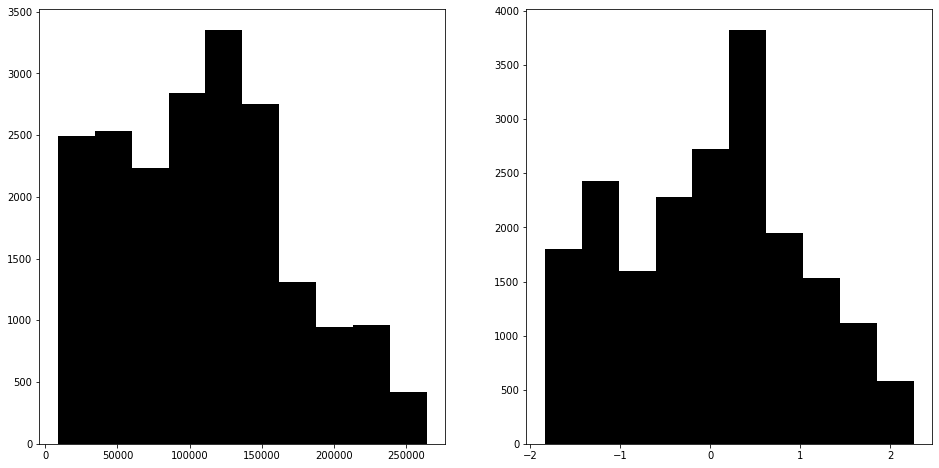

Crocus-017 

/n/n


<Figure size 576x576 with 0 Axes>

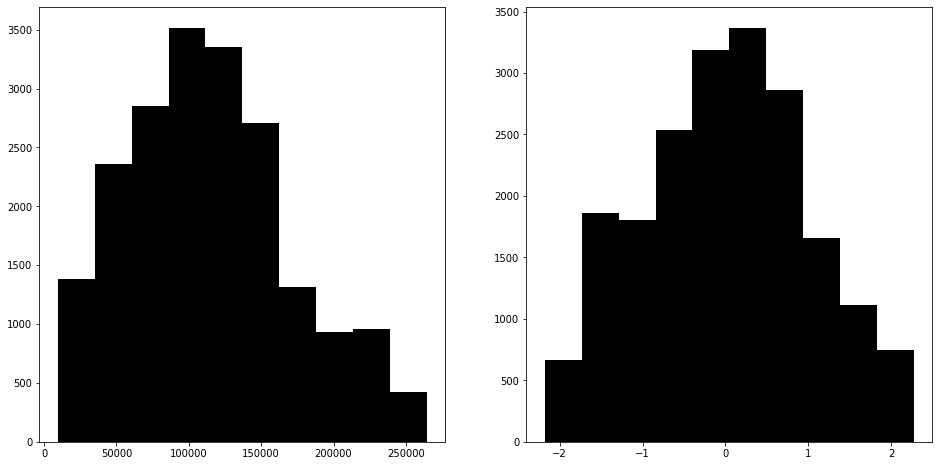

Crocus-018 

/n/n


<Figure size 576x576 with 0 Axes>

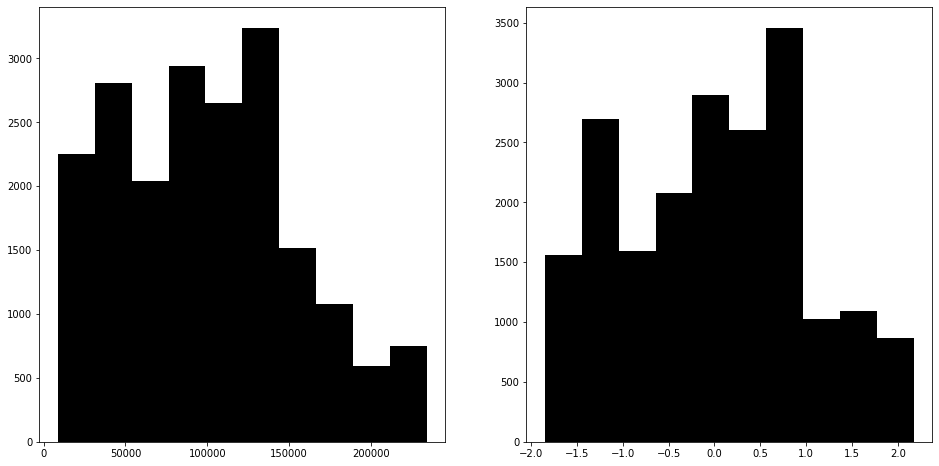

Crocus-019 

/n/n


<Figure size 576x576 with 0 Axes>

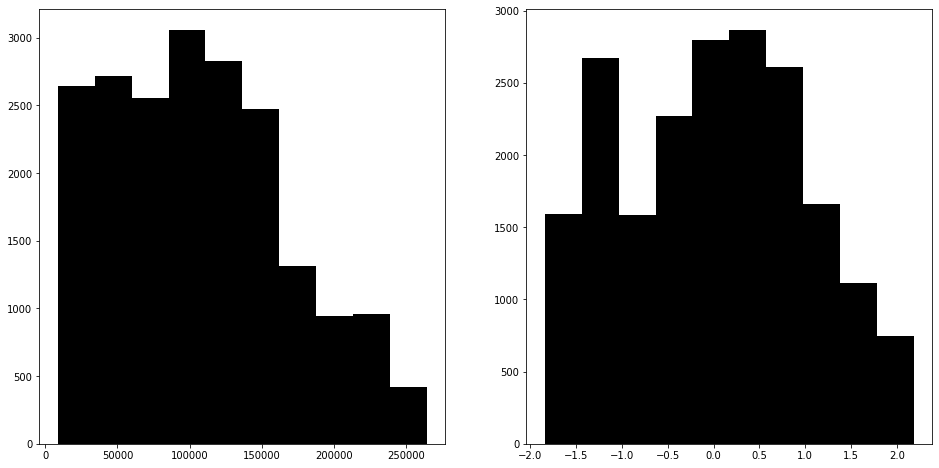

Crocus-020 

/n/n


<Figure size 576x576 with 0 Axes>

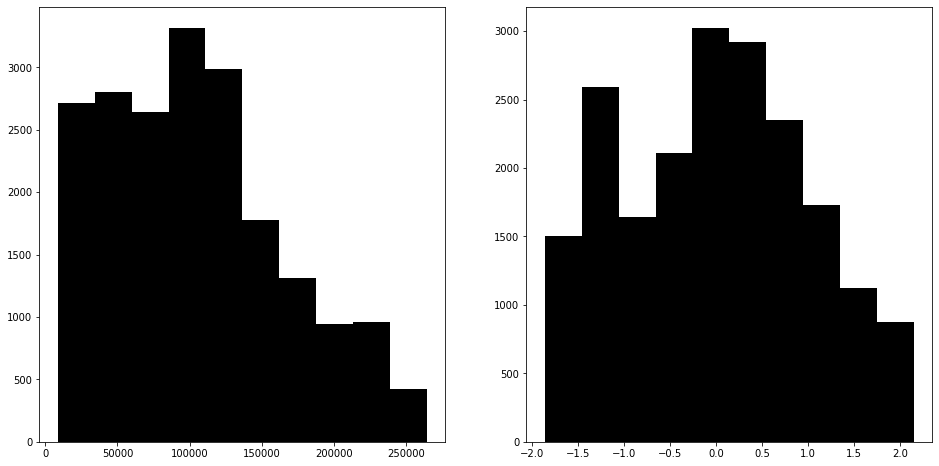

Crocus-022 

/n/n


<Figure size 576x576 with 0 Axes>

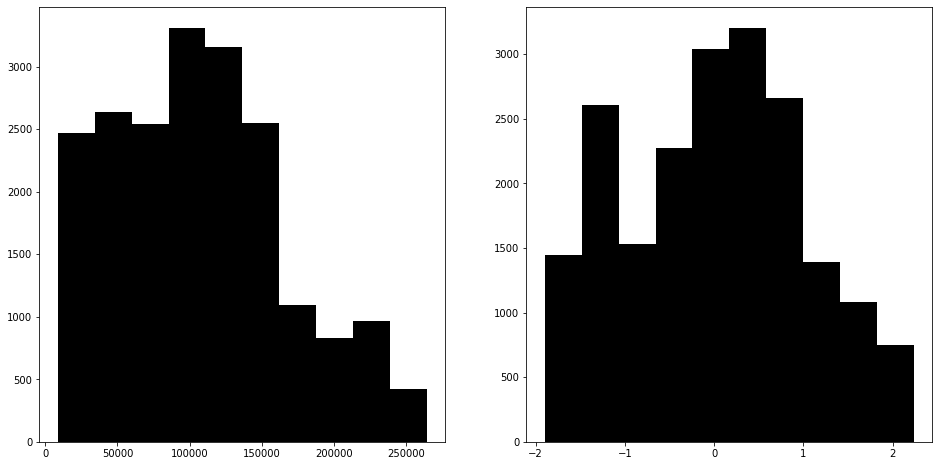

Crocus-023 

/n/n


<Figure size 576x576 with 0 Axes>

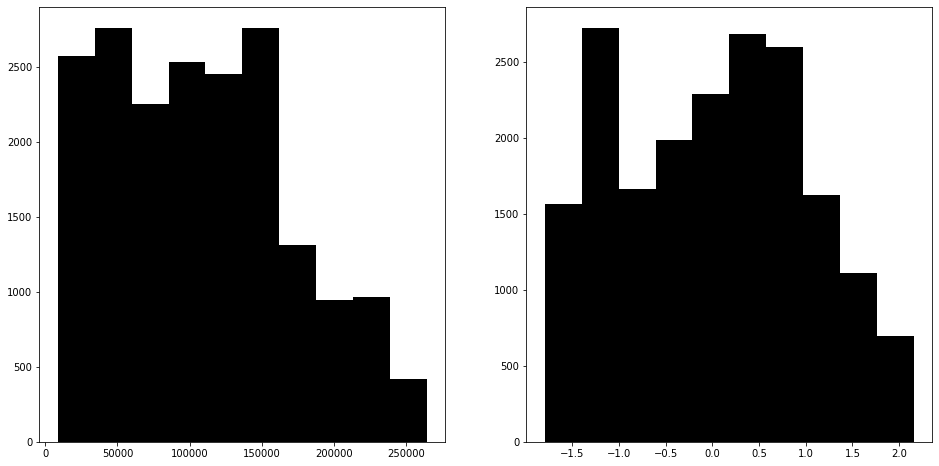

Crocus-025 

/n/n


<Figure size 576x576 with 0 Axes>

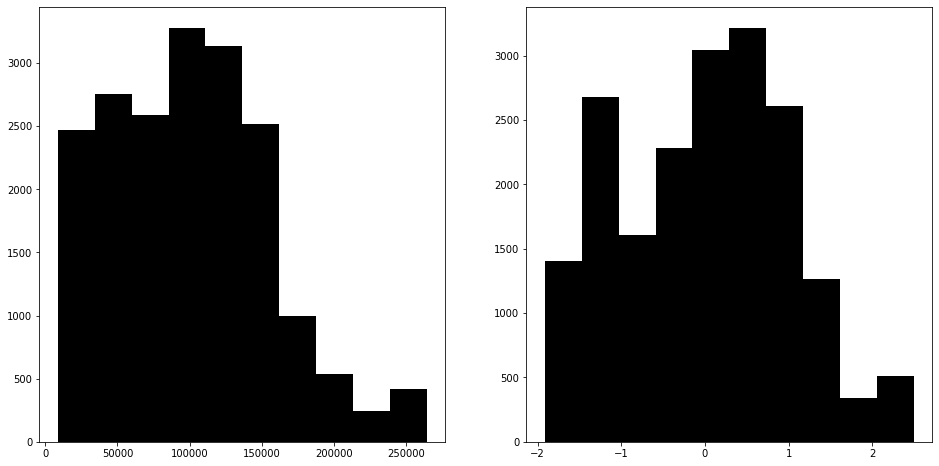

In [ ]:
def yj_histogram(features=['green_cumulative']):
  """This function takes a model and a list of features and will perform cross validation for that model and feature set"""
  df = open_dataframe()
  run_list = sorted(list(set(df.index)))
  run_list_iter = run_list
  results_ls = []
  # iterate through runs
  for run in run_list_iter:
    print(run, "\n\n/n/n")
    # split into test and training runs
    test_run = run
    training_runs = [x for x in run_list if x != run]
    # split data into test and train data
    train_df = df.loc[training_runs]
    test_df = df.loc[run]
    # split data into x and y for test and training
    x_train = train_df[features]
    y_train = train_df['Product']
    x_test = test_df[features]
    y_test = test_df['Product']
    # # Scale and then power transform data
    ss = StandardScaler()
    x_train_scaled = ss.fit_transform(x_train)
    x_test_scaled = ss.transform(x_test)
    pt = PowerTransformer(method='yeo-johnson')
    x_train_transformed = pt.fit_transform(x_train_scaled)
    x_test_transformed = pt.transform(x_test_scaled)
    # make histogram before and after x_test transform
    # fig = plt.figure(figsize=(8, 8))
    # fig, ax = plt.subplots(1, 2, figsize=(16,8))
    # x_test_values = x_test['green_cumulative'].values
    # ax[0].hist(x_test_values, label='Cumulative green', color='black')
    # ax[1].hist(x_test_transformed, label='Yeo-Johnson cumulative green', color='black')
    # plt.show()

    fig = plt.figure(figsize=(8, 8))
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    x_train_values = x_train['green_cumulative'].values
    ax[0].hist(x_train_values, label='Cumulative green', color='black')
    ax[1].hist(x_train_transformed, label='Yeo-Johnson cumulative green', color='black')
    plt.show()



    # # train model
    # trained_model = model_func(x_train, y_train)
    # # test model
    # y_pred = trained_model.predict(x_test)
    # # evaluate predictions
    # mae = mean_absolute_error(y_test, y_pred)
    # # plots
yj_histogram()


In [ ]:
def gaussian_distribution_plot(feature_ls, bins, df=False):
	matplotlib.rcParams.update({'font.size': 16})

	fig = plt.figure(figsize=(8, 8))
	fig, ax = plt.subplots(1, 2, figsize=(16,8))

	if df is False:
		df = open_dataset_csv()
	for idx, feature in enumerate(feature_ls):
		ax[idx].hist(df[feature], label=feature, color='black')

		ax[idx].autoscale(enable=True)
		ax[idx].set_ylim(0, 4800)
		# ax[idx].set_xlim(0, df[feature].max() *1.05)
		ax[idx].xaxis.set_major_locator(plt.MaxNLocator(5))
		ax[idx].yaxis.set_major_locator(plt.MaxNLocator(5))
		feature = feature.replace('_', ' ',).capitalize()
		feature = feature.replace('j', 'J')
		ax[idx].set(xlabel=feature, ylabel='Frequency')
	# aplt.ylabel('Frequency')
	# fig.tight_layout()
	# X = 10 * np.random.rand(5, 3)
	# plt.imshow(X, aspect='auto')
	# fig.suptitle("Affect of Yeo-Johnson power transformation on normality of green cumulative data", fontsize=28, y=0.95)
	plt.tight_layout()
	plt.savefig('histogram', dpi=300)
	plt.show()
